In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.preprocessing import MinMaxScaler, Normalizer, LabelEncoder

%matplotlib inline

In [2]:
train = pd.read_csv("../data/train.csv")
test = pd.read_csv("../data/test.csv")
test["is_promoted"] = np.nan
print train.shape, test.shape

(54808, 14) (23490, 14)


# Simple LGBM Model

In [3]:
train_id = train[["employee_id"]]
test_id = test[["employee_id"]]
target = train.is_promoted

train = train.drop(["employee_id","is_promoted"], axis=1)
test = test.drop(["employee_id","is_promoted"], axis=1)

data = pd.concat([train, test], axis=0).reset_index(drop=True)
data["previous_year_rating"] = data["previous_year_rating"].fillna(0)
data["education"] = data["education"].fillna("NoData")

# Feature Engineering Start
data["department_size"] = data["department"].map(data.groupby("department").size())

data["department_average_training_scores"] = data["department"].map(data.groupby("department")["avg_training_score"].apply(lambda x: np.array(x)))
data["percentile_average_training_score_in_department"] = data.apply(lambda x: ((x["department_average_training_scores"] < x["avg_training_score"]).astype(int).sum() + ((x["department_average_training_scores"] == x["avg_training_score"]).astype(int).sum()*0.5))/len(x["department_average_training_scores"]), axis=1)
data["t_average_training_score_in_department"] = data.apply(lambda x: (np.mean(x["department_average_training_scores"]) - x["avg_training_score"])/(np.std(x["department_average_training_scores"])/np.sqrt(len(x["department_average_training_scores"]))), axis=1)
data = data.drop(["department_average_training_scores"], axis=1)

data["kpi_positive_department_average_training_scores"] = data["department"].map(data.loc[data["KPIs_met >80%"] ==1].groupby("department")["avg_training_score"].apply(lambda x: np.array(x)))
data["percentile_kpi_positive_average_training_score_in_department"] = data.apply(lambda x: ((x["kpi_positive_department_average_training_scores"] < x["avg_training_score"]).astype(int).sum() + ((x["kpi_positive_department_average_training_scores"] == x["avg_training_score"]).astype(int).sum()*0.5))/len(x["kpi_positive_department_average_training_scores"]), axis=1)
data = data.drop(["kpi_positive_department_average_training_scores"], axis=1)

# Feature Engineering End


data = pd.get_dummies(data, columns = data.select_dtypes(include='object').columns)

train = data[:train.shape[0]]
test = data[train.shape[0]:]

In [4]:
def f1_score_calculator(y_true, y_pred):
    bst = 0
    split_by = 0.0
    for i in range(100):
        fs = f1_score(y_true, (y_pred>i/100.0).astype(int))
        if fs > bst:
            bst , split_by = fs, i/100.0
        else:
            pass
    return split_by, bst 

In [5]:
import lightgbm as lgb
def model_tree(x_train, x_test, y_train, y_test, test, meta_train, meta_test,train_index, test_index,fold_id):
    dtrain = lgb.Dataset(x_train, label=y_train)
    dval = lgb.Dataset(x_test, label=y_test)
    params = {
        'num_leaves': 32, 
        'reg_alpha': 0.04, 
        'n_jobs': -1, 
        'colsample_bytree': 0.9497036, 
        'silent': -1, 
        'subsample_for_bin': 200000, 
        'subsample_freq': 1, 
        'learning_rate': 0.02, 
        'boosting_type': 'gbdt', 
        'nthread': 8, 
        'min_child_weight': 40, 
        'min_split_gain': 0.0222415, 
        'n_estimators': 10000, 
        'subsample': 0.8715623, 
        'reg_lambda': 0.073, 
        'objective': "binary",
        'verbose': -1, 
        'min_child_samples': 20, 
        'max_depth': 4, 
        'class_weight': None,
        "nthread":8,
        "bagging_seed" : 42,
        "seed":98,
        "metric":"auc"
    }
    model = lgb.train(params, dtrain, num_boost_round=5000,valid_sets=[dtrain, dval], early_stopping_rounds=200, verbose_eval=100)
    meta_train[test_index] = model.predict(x_test, num_iteration=model.best_iteration or 5000)
    split, bst = f1_score_calculator(y_test, meta_train[test_index])
    
    meta_train[test_index] = (meta_train[test_index] > split).astype(int)
    meta_test.append((model.predict(test, num_iteration=model.best_iteration or 5000) > split).astype(int))
    
    print "Fold {} best Split {} and best Score {}".format(fold_id,split, bst)
        
    # Calculate Feature Importance
    global feature_importance
    gain = model.feature_importance('gain')
    fold_feature_importance = pd.DataFrame({'feature':model.feature_name(), 'split':model.feature_importance('split'), 'gain':100 * gain / gain.sum()})
    feature_importance = feature_importance.append(fold_feature_importance, ignore_index=True) 

In [6]:
meta_train = np.zeros(train.shape[0])
meta_test = []
feature_importance = pd.DataFrame()

kf = StratifiedKFold(n_splits= 497, shuffle=True, random_state=1343)
for fold_id, (train_index, test_index) in enumerate(kf.split(train, target)):
    x_train, x_test = train.iloc[train_index], train.iloc[test_index]
    y_train, y_test = target[train_index], target[test_index]

    model_tree(x_train, x_test, y_train, y_test, test, meta_train, meta_test,train_index, test_index,fold_id)
print "Overall Score: {}".format(f1_score(target, meta_train))

train_id["is_promoted"] = meta_train
test_id["is_promoted"] = (np.array(meta_test).T.mean(axis=1) > 0.5).astype(int)

/anaconda2/lib/python2.7/site-packages/lightgbm/engine.py:99: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda2/lib/python2.7/site-packages/lightgbm/basic.py:657: UserWarning: silent keyword has been found in `params` and will be ignored. Please use silent argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))


Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.903707	valid_1's auc: 0.941584
[200]	training's auc: 0.911211	valid_1's auc: 0.940594
Early stopping, best iteration is:
[82]	training's auc: 0.901199	valid_1's auc: 0.944059
Fold 0 best Split 0.2 and best Score 0.5625


/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.90328	valid_1's auc: 0.943564
[200]	training's auc: 0.910387	valid_1's auc: 0.953465
[300]	training's auc: 0.9133	valid_1's auc: 0.949505
[400]	training's auc: 0.915763	valid_1's auc: 0.952475
Early stopping, best iteration is:
[231]	training's auc: 0.911708	valid_1's auc: 0.954455
Fold 1 best Split 0.18 and best Score 0.777777777778
Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.903659	valid_1's auc: 0.881683
[200]	training's auc: 0.910512	valid_1's auc: 0.884158
Early stopping, best iteration is:
[76]	training's auc: 0.900217	valid_1's auc: 0.886634
Fold 2 best Split 0.23 and best Score 0.588235294118
Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.90289	valid_1's auc: 0.987129
[200]	training's auc: 0.91007	valid_1's auc: 0.989109
[300]	training's auc: 0.913191	valid_1's auc: 0.989109
Early stopping, best iteration is:
[

Fold 21 best Split 0.26 and best Score 0.666666666667
Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.903631	valid_1's auc: 0.940594
[200]	training's auc: 0.91048	valid_1's auc: 0.947525
[300]	training's auc: 0.913467	valid_1's auc: 0.940594
Early stopping, best iteration is:
[137]	training's auc: 0.906378	valid_1's auc: 0.952475
Fold 22 best Split 0.19 and best Score 0.736842105263
Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.90371	valid_1's auc: 0.909901
[200]	training's auc: 0.910376	valid_1's auc: 0.917327
[300]	training's auc: 0.913241	valid_1's auc: 0.924257
[400]	training's auc: 0.915858	valid_1's auc: 0.925743
[500]	training's auc: 0.917453	valid_1's auc: 0.925743
[600]	training's auc: 0.918989	valid_1's auc: 0.925743
[700]	training's auc: 0.920354	valid_1's auc: 0.927723
[800]	training's auc: 0.92139	valid_1's auc: 0.930693
[900]	training's auc: 0.922379	valid_1's auc: 0.930693
[1000]	training's a

Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.903991	valid_1's auc: 0.832673
[200]	training's auc: 0.910437	valid_1's auc: 0.822772
Early stopping, best iteration is:
[72]	training's auc: 0.900725	valid_1's auc: 0.842574
Fold 42 best Split 0.16 and best Score 0.357142857143
Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.903214	valid_1's auc: 0.889604
[200]	training's auc: 0.910592	valid_1's auc: 0.893069
Early stopping, best iteration is:
[13]	training's auc: 0.894991	valid_1's auc: 0.915347
Fold 43 best Split 0.43 and best Score 0.75
Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.903818	valid_1's auc: 0.89604
[200]	training's auc: 0.910545	valid_1's auc: 0.922772
[300]	training's auc: 0.913317	valid_1's auc: 0.910891
Early stopping, best iteration is:
[180]	training's auc: 0.909521	valid_1's auc: 0.925743
Fold 44 best Split 0.17 and best Score 0.545454545455
Trainin

[300]	training's auc: 0.91319	valid_1's auc: 0.956436
[400]	training's auc: 0.915819	valid_1's auc: 0.959406
Early stopping, best iteration is:
[201]	training's auc: 0.910728	valid_1's auc: 0.961386
Fold 61 best Split 0.15 and best Score 0.64
Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.903725	valid_1's auc: 0.944554
[200]	training's auc: 0.910373	valid_1's auc: 0.946535
Early stopping, best iteration is:
[16]	training's auc: 0.895219	valid_1's auc: 0.957426
Fold 62 best Split 0.44 and best Score 0.666666666667
Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.903623	valid_1's auc: 0.914851
[200]	training's auc: 0.910695	valid_1's auc: 0.913861
[300]	training's auc: 0.913342	valid_1's auc: 0.921782
[400]	training's auc: 0.915976	valid_1's auc: 0.919802
Early stopping, best iteration is:
[278]	training's auc: 0.912459	valid_1's auc: 0.926733
Fold 63 best Split 0.32 and best Score 0.571428571429
Training until

[300]	training's auc: 0.913771	valid_1's auc: 0.821782
[400]	training's auc: 0.916163	valid_1's auc: 0.827723
[500]	training's auc: 0.917876	valid_1's auc: 0.827723
[600]	training's auc: 0.919448	valid_1's auc: 0.815842
Early stopping, best iteration is:
[417]	training's auc: 0.916432	valid_1's auc: 0.831683
Fold 80 best Split 0.15 and best Score 0.424242424242
Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.90371	valid_1's auc: 0.902475
[200]	training's auc: 0.910534	valid_1's auc: 0.908416
[300]	training's auc: 0.913256	valid_1's auc: 0.90495
[400]	training's auc: 0.915649	valid_1's auc: 0.908911
Early stopping, best iteration is:
[206]	training's auc: 0.910772	valid_1's auc: 0.909901
Fold 81 best Split 0.21 and best Score 0.588235294118
Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.903544	valid_1's auc: 0.940594
[200]	training's auc: 0.910365	valid_1's auc: 0.938614
[300]	training's auc: 0.913168	valid_1

[200]	training's auc: 0.910494	valid_1's auc: 0.951485
[300]	training's auc: 0.913435	valid_1's auc: 0.94604
[400]	training's auc: 0.915779	valid_1's auc: 0.955446
Early stopping, best iteration is:
[264]	training's auc: 0.912398	valid_1's auc: 0.957921
Fold 100 best Split 0.17 and best Score 0.631578947368
Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.903361	valid_1's auc: 0.935644
[200]	training's auc: 0.91072	valid_1's auc: 0.933663
Early stopping, best iteration is:
[73]	training's auc: 0.900148	valid_1's auc: 0.941089
Fold 101 best Split 0.72 and best Score 0.666666666667
Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.903795	valid_1's auc: 0.961881
[200]	training's auc: 0.910201	valid_1's auc: 0.966337
[300]	training's auc: 0.913098	valid_1's auc: 0.965347
Early stopping, best iteration is:
[188]	training's auc: 0.90967	valid_1's auc: 0.967327
Fold 102 best Split 0.17 and best Score 0.75
Training unti

[500]	training's auc: 0.917606	valid_1's auc: 0.890099
[600]	training's auc: 0.919074	valid_1's auc: 0.893069
[700]	training's auc: 0.920431	valid_1's auc: 0.892079
[800]	training's auc: 0.921374	valid_1's auc: 0.892079
Early stopping, best iteration is:
[653]	training's auc: 0.919877	valid_1's auc: 0.89505
Fold 120 best Split 0.23 and best Score 0.5
Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.903856	valid_1's auc: 0.890594
[200]	training's auc: 0.910989	valid_1's auc: 0.885149
Early stopping, best iteration is:
[81]	training's auc: 0.901036	valid_1's auc: 0.896535
Fold 121 best Split 0.21 and best Score 0.428571428571
Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.902465	valid_1's auc: 0.906931
[200]	training's auc: 0.910452	valid_1's auc: 0.906931
[300]	training's auc: 0.913325	valid_1's auc: 0.916832
[400]	training's auc: 0.91579	valid_1's auc: 0.921782
[500]	training's auc: 0.917436	valid_1's auc: 0.

[500]	training's auc: 0.917767	valid_1's auc: 0.9
[600]	training's auc: 0.919443	valid_1's auc: 0.90297
[700]	training's auc: 0.920697	valid_1's auc: 0.894059
Early stopping, best iteration is:
[552]	training's auc: 0.918663	valid_1's auc: 0.906931
Fold 139 best Split 0.17 and best Score 0.526315789474
Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.903764	valid_1's auc: 0.906436
[200]	training's auc: 0.910628	valid_1's auc: 0.929703
[300]	training's auc: 0.913301	valid_1's auc: 0.930693
Early stopping, best iteration is:
[182]	training's auc: 0.909531	valid_1's auc: 0.934653
Fold 140 best Split 0.19 and best Score 0.666666666667
Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.902948	valid_1's auc: 0.889109
[200]	training's auc: 0.910391	valid_1's auc: 0.884158
[300]	training's auc: 0.913215	valid_1's auc: 0.89703
[400]	training's auc: 0.915727	valid_1's auc: 0.9
[500]	training's auc: 0.917429	valid_1's auc: 

[400]	training's auc: 0.916116	valid_1's auc: 0.846535
[500]	training's auc: 0.917746	valid_1's auc: 0.854455
[600]	training's auc: 0.919261	valid_1's auc: 0.855446
[700]	training's auc: 0.920528	valid_1's auc: 0.859406
[800]	training's auc: 0.921506	valid_1's auc: 0.861386
[900]	training's auc: 0.922402	valid_1's auc: 0.861386
[1000]	training's auc: 0.923174	valid_1's auc: 0.865347
[1100]	training's auc: 0.924073	valid_1's auc: 0.862376
Early stopping, best iteration is:
[997]	training's auc: 0.923164	valid_1's auc: 0.865347
Fold 161 best Split 0.1 and best Score 0.418604651163
Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.90431	valid_1's auc: 0.872277
[200]	training's auc: 0.91067	valid_1's auc: 0.890099
[300]	training's auc: 0.91348	valid_1's auc: 0.884158
Early stopping, best iteration is:
[166]	training's auc: 0.908643	valid_1's auc: 0.90297
Fold 162 best Split 0.24 and best Score 0.533333333333
Training until validation scores don't improv

Early stopping, best iteration is:
[185]	training's auc: 0.909566	valid_1's auc: 0.945545
Fold 180 best Split 0.17 and best Score 0.615384615385
Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.903799	valid_1's auc: 0.89901
[200]	training's auc: 0.910462	valid_1's auc: 0.910891
Early stopping, best iteration is:
[37]	training's auc: 0.894674	valid_1's auc: 0.919307
Fold 181 best Split 0.45 and best Score 0.75
Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.903652	valid_1's auc: 0.947525
[200]	training's auc: 0.910375	valid_1's auc: 0.948515
[300]	training's auc: 0.9132	valid_1's auc: 0.951485
[400]	training's auc: 0.91571	valid_1's auc: 0.954455
[500]	training's auc: 0.917322	valid_1's auc: 0.949505
Early stopping, best iteration is:
[382]	training's auc: 0.915461	valid_1's auc: 0.955446
Fold 182 best Split 0.17 and best Score 0.666666666667
Training until validation scores don't improve for 200 rounds.
[100]	

Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.903901	valid_1's auc: 0.852585
[200]	training's auc: 0.910526	valid_1's auc: 0.853685
[300]	training's auc: 0.913384	valid_1's auc: 0.864686
[400]	training's auc: 0.915772	valid_1's auc: 0.860286
[500]	training's auc: 0.917489	valid_1's auc: 0.864686
Early stopping, best iteration is:
[300]	training's auc: 0.913384	valid_1's auc: 0.864686
Fold 200 best Split 0.13 and best Score 0.432432432432
Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.904293	valid_1's auc: 0.880088
[200]	training's auc: 0.910619	valid_1's auc: 0.888889
[300]	training's auc: 0.913316	valid_1's auc: 0.873487
Early stopping, best iteration is:
[153]	training's auc: 0.90783	valid_1's auc: 0.89659
Fold 201 best Split 0.16 and best Score 0.444444444444
Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.903797	valid_1's auc: 0.950495
[200]	training's auc: 0.9100

Fold 219 best Split 0.18 and best Score 0.666666666667
Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.903542	valid_1's auc: 0.90429
[200]	training's auc: 0.910679	valid_1's auc: 0.90099
Early stopping, best iteration is:
[17]	training's auc: 0.893537	valid_1's auc: 0.919142
Fold 220 best Split 0.42 and best Score 0.666666666667
Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.903267	valid_1's auc: 0.920792
[200]	training's auc: 0.910593	valid_1's auc: 0.920792
[300]	training's auc: 0.91329	valid_1's auc: 0.909791
Early stopping, best iteration is:
[117]	training's auc: 0.904941	valid_1's auc: 0.931793
Fold 221 best Split 0.17 and best Score 0.615384615385
Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.903924	valid_1's auc: 0.933443
[200]	training's auc: 0.910733	valid_1's auc: 0.946095
[300]	training's auc: 0.913515	valid_1's auc: 0.949395
[400]	training's auc: 0.915856

Fold 242 best Split 0.53 and best Score 0.714285714286
Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.903586	valid_1's auc: 0.951595
[200]	training's auc: 0.910949	valid_1's auc: 0.960396
[300]	training's auc: 0.913334	valid_1's auc: 0.965897
[400]	training's auc: 0.915805	valid_1's auc: 0.968097
[500]	training's auc: 0.91747	valid_1's auc: 0.969197
[600]	training's auc: 0.919104	valid_1's auc: 0.969197
Early stopping, best iteration is:
[439]	training's auc: 0.916387	valid_1's auc: 0.969197
Fold 243 best Split 0.4 and best Score 0.8
Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.9031	valid_1's auc: 0.90099
[200]	training's auc: 0.910268	valid_1's auc: 0.89879
Early stopping, best iteration is:
[1]	training's auc: 0.883319	valid_1's auc: 0.913091
Fold 244 best Split 0.5 and best Score 0.666666666667
Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.903698	valid_1's auc: 

Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.903476	valid_1's auc: 0.913091
[200]	training's auc: 0.910671	valid_1's auc: 0.89769
Early stopping, best iteration is:
[74]	training's auc: 0.900342	valid_1's auc: 0.917492
Fold 264 best Split 0.23 and best Score 0.47619047619
Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.90337	valid_1's auc: 0.914191
[200]	training's auc: 0.910472	valid_1's auc: 0.922442
[300]	training's auc: 0.913437	valid_1's auc: 0.918042
Early stopping, best iteration is:
[178]	training's auc: 0.909319	valid_1's auc: 0.926843
Fold 265 best Split 0.17 and best Score 0.588235294118
Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.90392	valid_1's auc: 0.868537
[200]	training's auc: 0.910645	valid_1's auc: 0.873487
[300]	training's auc: 0.913357	valid_1's auc: 0.871287
[400]	training's auc: 0.915981	valid_1's auc: 0.885589
[500]	training's auc: 0.917751	

[900]	training's auc: 0.922626	valid_1's auc: 0.925193
[1000]	training's auc: 0.923423	valid_1's auc: 0.924092
[1100]	training's auc: 0.924272	valid_1's auc: 0.927393
[1200]	training's auc: 0.925093	valid_1's auc: 0.929593
[1300]	training's auc: 0.925777	valid_1's auc: 0.930693
[1400]	training's auc: 0.92647	valid_1's auc: 0.929593
Early stopping, best iteration is:
[1246]	training's auc: 0.925387	valid_1's auc: 0.932893
Fold 282 best Split 0.29 and best Score 0.625
Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.903638	valid_1's auc: 0.836634
[200]	training's auc: 0.910826	valid_1's auc: 0.872937
[300]	training's auc: 0.913385	valid_1's auc: 0.863586
Early stopping, best iteration is:
[189]	training's auc: 0.91028	valid_1's auc: 0.876238
Fold 283 best Split 0.14 and best Score 0.432432432432
Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.903288	valid_1's auc: 0.863036
[200]	training's auc: 0.910794	valid_1'

Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.903522	valid_1's auc: 0.942244
[200]	training's auc: 0.910927	valid_1's auc: 0.941694
[300]	training's auc: 0.913164	valid_1's auc: 0.944994
[400]	training's auc: 0.915617	valid_1's auc: 0.954895
[500]	training's auc: 0.917481	valid_1's auc: 0.954895
[600]	training's auc: 0.919051	valid_1's auc: 0.953795
Early stopping, best iteration is:
[414]	training's auc: 0.915933	valid_1's auc: 0.958196
Fold 304 best Split 0.42 and best Score 0.714285714286
Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.903556	valid_1's auc: 0.90429
[200]	training's auc: 0.910895	valid_1's auc: 0.905941
[300]	training's auc: 0.913549	valid_1's auc: 0.892189
Early stopping, best iteration is:
[183]	training's auc: 0.909891	valid_1's auc: 0.912541
Fold 305 best Split 0.15 and best Score 0.5
Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.903505	valid_1

[100]	training's auc: 0.903336	valid_1's auc: 0.844334
[200]	training's auc: 0.910221	valid_1's auc: 0.875688
[300]	training's auc: 0.913316	valid_1's auc: 0.880088
[400]	training's auc: 0.915673	valid_1's auc: 0.888889
[500]	training's auc: 0.91743	valid_1's auc: 0.892189
[600]	training's auc: 0.919051	valid_1's auc: 0.893289
[700]	training's auc: 0.920452	valid_1's auc: 0.893289
Early stopping, best iteration is:
[515]	training's auc: 0.917729	valid_1's auc: 0.894389
Fold 325 best Split 0.25 and best Score 0.714285714286
Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.903483	valid_1's auc: 0.941144
[200]	training's auc: 0.910457	valid_1's auc: 0.935094
Early stopping, best iteration is:
[37]	training's auc: 0.895063	valid_1's auc: 0.941694
Fold 326 best Split 0.56 and best Score 0.714285714286
Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.903533	valid_1's auc: 0.881188
[200]	training's auc: 0.91069	valid_

[1800]	training's auc: 0.928608	valid_1's auc: 0.959296
[1900]	training's auc: 0.929154	valid_1's auc: 0.958196
Early stopping, best iteration is:
[1750]	training's auc: 0.928314	valid_1's auc: 0.960396
Fold 344 best Split 0.14 and best Score 0.620689655172
Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.903483	valid_1's auc: 0.825633
[200]	training's auc: 0.910884	valid_1's auc: 0.831133
[300]	training's auc: 0.913648	valid_1's auc: 0.830583
Early stopping, best iteration is:
[138]	training's auc: 0.90656	valid_1's auc: 0.845435
Fold 345 best Split 0.16 and best Score 0.387096774194
Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.903615	valid_1's auc: 0.927393
[200]	training's auc: 0.910827	valid_1's auc: 0.907591
Early stopping, best iteration is:
[69]	training's auc: 0.900092	valid_1's auc: 0.936194
Fold 346 best Split 0.26 and best Score 0.5
Training until validation scores don't improve for 200 rounds.
[

[200]	training's auc: 0.910449	valid_1's auc: 0.941694
[300]	training's auc: 0.913231	valid_1's auc: 0.948295
[400]	training's auc: 0.916078	valid_1's auc: 0.951595
[500]	training's auc: 0.917617	valid_1's auc: 0.952695
[600]	training's auc: 0.919117	valid_1's auc: 0.952695
[700]	training's auc: 0.920337	valid_1's auc: 0.951595
[800]	training's auc: 0.92144	valid_1's auc: 0.951595
[900]	training's auc: 0.922411	valid_1's auc: 0.949395
Early stopping, best iteration is:
[722]	training's auc: 0.920578	valid_1's auc: 0.955996
Fold 366 best Split 0.13 and best Score 0.615384615385
Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.903529	valid_1's auc: 0.929593
[200]	training's auc: 0.910413	valid_1's auc: 0.962596
[300]	training's auc: 0.913108	valid_1's auc: 0.957096
[400]	training's auc: 0.915538	valid_1's auc: 0.969197
[500]	training's auc: 0.917262	valid_1's auc: 0.973597
[600]	training's auc: 0.918947	valid_1's auc: 0.979098
[700]	training's auc: 0

[100]	training's auc: 0.90389	valid_1's auc: 0.927393
[200]	training's auc: 0.91011	valid_1's auc: 0.920242
Early stopping, best iteration is:
[98]	training's auc: 0.903544	valid_1's auc: 0.927943
Fold 385 best Split 0.2 and best Score 0.571428571429
Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.903858	valid_1's auc: 0.869087
[200]	training's auc: 0.910796	valid_1's auc: 0.872387
[300]	training's auc: 0.913513	valid_1's auc: 0.875688
[400]	training's auc: 0.916053	valid_1's auc: 0.878988
[500]	training's auc: 0.917685	valid_1's auc: 0.880088
Early stopping, best iteration is:
[351]	training's auc: 0.915092	valid_1's auc: 0.880088
Fold 386 best Split 0.17 and best Score 0.545454545455
Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.90348	valid_1's auc: 0.907041
[200]	training's auc: 0.910712	valid_1's auc: 0.89769
Early stopping, best iteration is:
[49]	training's auc: 0.896535	valid_1's auc: 0.912541
Fold 3

[300]	training's auc: 0.913457	valid_1's auc: 0.864686
Early stopping, best iteration is:
[188]	training's auc: 0.909949	valid_1's auc: 0.869087
Fold 406 best Split 0.15 and best Score 0.4
Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.903799	valid_1's auc: 0.870187
[200]	training's auc: 0.910464	valid_1's auc: 0.885589
[300]	training's auc: 0.913237	valid_1's auc: 0.884488
Early stopping, best iteration is:
[156]	training's auc: 0.90767	valid_1's auc: 0.887789
Fold 407 best Split 0.17 and best Score 0.526315789474
Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.903413	valid_1's auc: 0.955996
[200]	training's auc: 0.910375	valid_1's auc: 0.964796
[300]	training's auc: 0.913098	valid_1's auc: 0.966997
[400]	training's auc: 0.915755	valid_1's auc: 0.959296
Early stopping, best iteration is:
[287]	training's auc: 0.912693	valid_1's auc: 0.966997
Fold 408 best Split 0.3 and best Score 0.8
Training until validati

[300]	training's auc: 0.913517	valid_1's auc: 0.881188
[400]	training's auc: 0.916152	valid_1's auc: 0.880088
[500]	training's auc: 0.917716	valid_1's auc: 0.885589
[600]	training's auc: 0.919258	valid_1's auc: 0.883388
Early stopping, best iteration is:
[476]	training's auc: 0.917352	valid_1's auc: 0.885589
Fold 424 best Split 0.24 and best Score 0.571428571429
Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.903671	valid_1's auc: 0.917492
[200]	training's auc: 0.910728	valid_1's auc: 0.919692
Early stopping, best iteration is:
[10]	training's auc: 0.891313	valid_1's auc: 0.925193
Fold 425 best Split 0.45 and best Score 0.461538461538
Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.90388	valid_1's auc: 0.830033
[200]	training's auc: 0.910811	valid_1's auc: 0.810231
Early stopping, best iteration is:
[3]	training's auc: 0.887716	valid_1's auc: 0.855336
Fold 426 best Split 0.48 and best Score 0.47619047619
Trai

Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.903935	valid_1's auc: 0.823889
[200]	training's auc: 0.91088	valid_1's auc: 0.816667
Early stopping, best iteration is:
[7]	training's auc: 0.89037	valid_1's auc: 0.859444
Fold 445 best Split 0.45 and best Score 0.296296296296
Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.903824	valid_1's auc: 0.936667
[200]	training's auc: 0.910801	valid_1's auc: 0.927778
Early stopping, best iteration is:
[37]	training's auc: 0.895615	valid_1's auc: 0.948889
Fold 446 best Split 0.31 and best Score 0.615384615385
Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.903442	valid_1's auc: 0.915556
[200]	training's auc: 0.910758	valid_1's auc: 0.925556
[300]	training's auc: 0.913424	valid_1's auc: 0.935556
[400]	training's auc: 0.915979	valid_1's auc: 0.932222
Early stopping, best iteration is:
[228]	training's auc: 0.911886	valid_1's auc: 0.935

Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.904006	valid_1's auc: 0.846111
[200]	training's auc: 0.910611	valid_1's auc: 0.825556
Early stopping, best iteration is:
[60]	training's auc: 0.898846	valid_1's auc: 0.858889
Fold 464 best Split 0.26 and best Score 0.428571428571
Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.903761	valid_1's auc: 0.831667
[200]	training's auc: 0.910616	valid_1's auc: 0.836667
Early stopping, best iteration is:
[1]	training's auc: 0.883447	valid_1's auc: 0.848889
Fold 465 best Split 0.5 and best Score 0.181818181818
Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.903441	valid_1's auc: 0.852222
[200]	training's auc: 0.910722	valid_1's auc: 0.856667
Early stopping, best iteration is:
[1]	training's auc: 0.879315	valid_1's auc: 0.865
Fold 466 best Split 0.5 and best Score 0.666666666667
Training until validation scores don't improve for 200 r

[700]	training's auc: 0.92018	valid_1's auc: 0.941111
[800]	training's auc: 0.921247	valid_1's auc: 0.945556
[900]	training's auc: 0.922175	valid_1's auc: 0.947778
[1000]	training's auc: 0.923049	valid_1's auc: 0.947778
Early stopping, best iteration is:
[880]	training's auc: 0.921986	valid_1's auc: 0.948889
Fold 482 best Split 0.25 and best Score 0.666666666667
Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.90408	valid_1's auc: 0.895556
[200]	training's auc: 0.91057	valid_1's auc: 0.905556
[300]	training's auc: 0.913368	valid_1's auc: 0.911111
[400]	training's auc: 0.915887	valid_1's auc: 0.905556
Early stopping, best iteration is:
[235]	training's auc: 0.911859	valid_1's auc: 0.911111
Fold 483 best Split 0.16 and best Score 0.631578947368
Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.903478	valid_1's auc: 0.880556
[200]	training's auc: 0.910736	valid_1's auc: 0.888333
[300]	training's auc: 0.913373	valid

In [10]:
test_id.to_csv("csv/prediction7.csv", index = False)

In [11]:
test_id["is_promoted"].mean()

0.05755640698169434

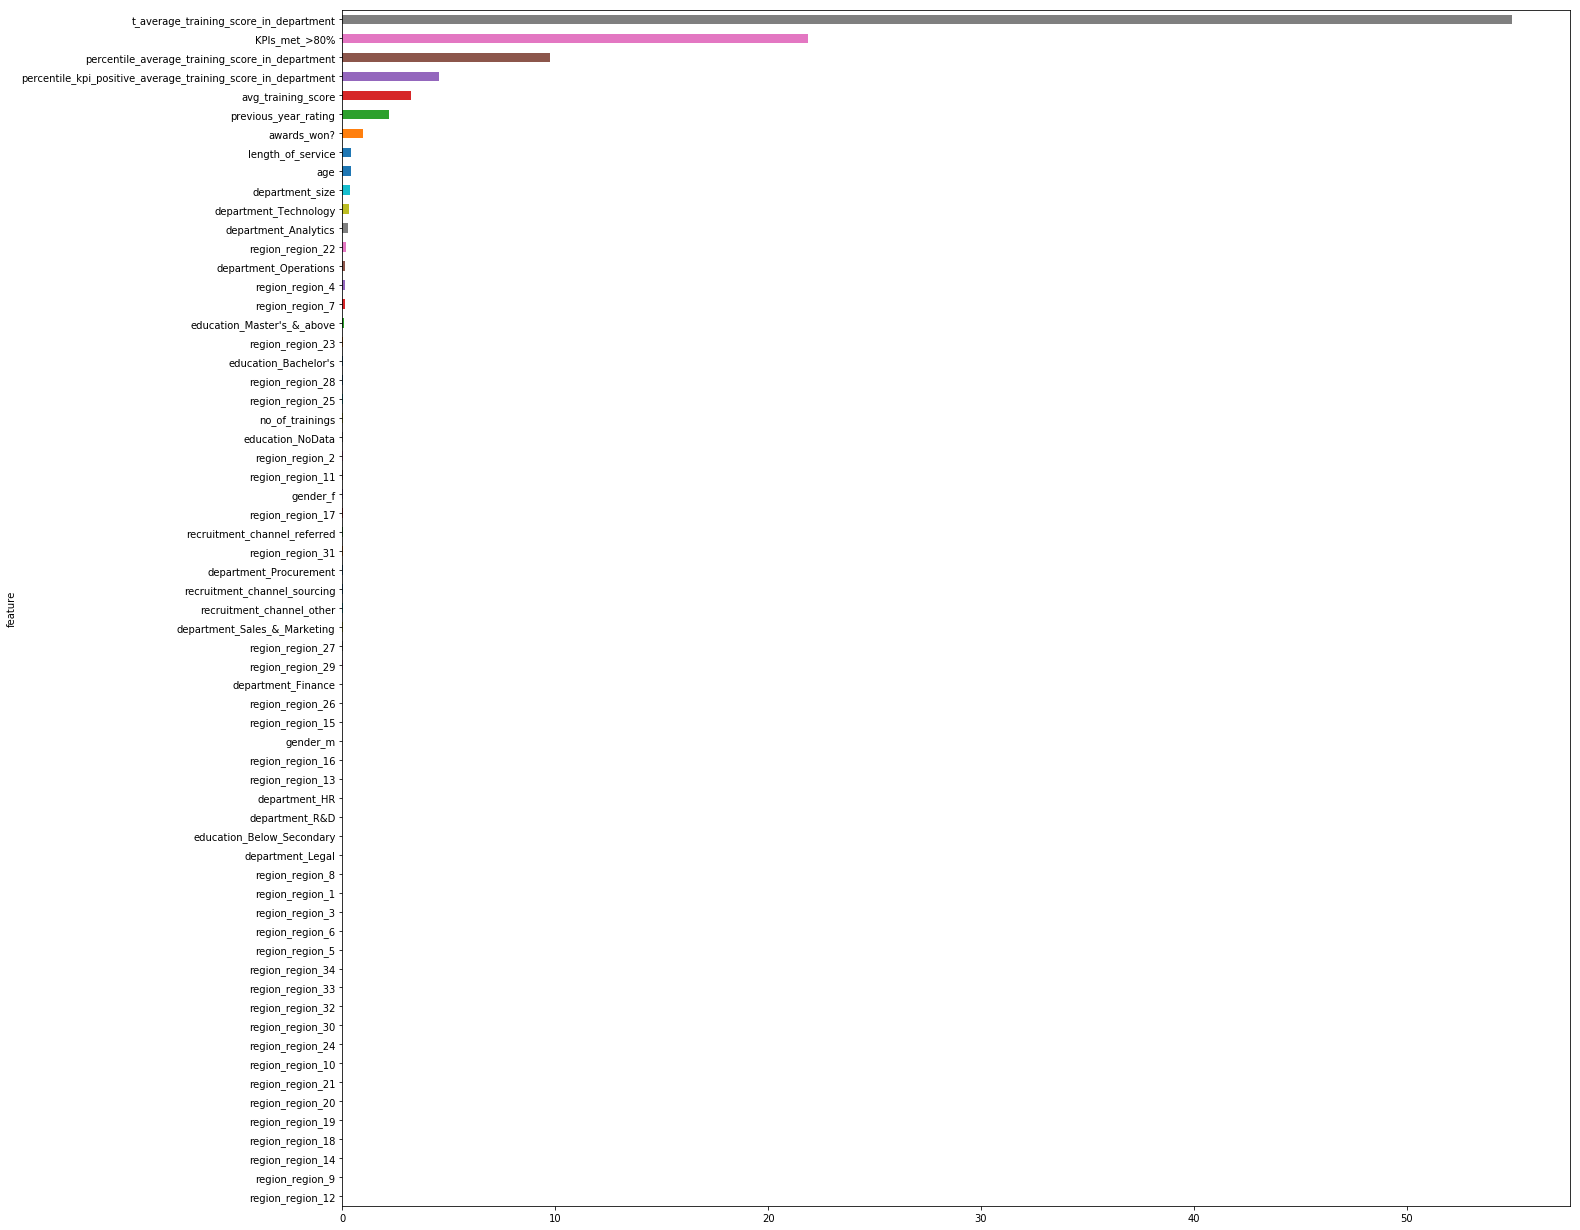

In [12]:
feature_importance.groupby("feature")["gain"].mean().sort_values().plot(kind = "barh", figsize = (22,22))